# Import libs that we'll need for the project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import percentile
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.dates as mdates
import operator
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

#file created by us that has functions 
from funcs import * 


#just to remove the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Split the project into steps

1. Read the file
2. Remove Outliers  
   1. Quartiles
   2. Deviation **(method used)**
   3. By hand in special cases 
3. Normalization and standardization of the data
   1. Z-Score
   2. Min Max **(method used)**
4. Split the data into train, test and validation sets
5. Train the NN 
   1. KFold 
   2. Regular train with train set, validation and test set
6. Adjust parameters

## Read the file and analyze data:

In [2]:
data_df = pd.read_csv("Proj1_Dataset.csv", sep=",", decimal=".")

data_df=parse_date_time(data_df)

data_df.to_csv("Proj1_Dataset_changed.csv")


#run to view the data
#plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)

#scatter_plot(data_df, temperature=True, C02_PIR=False, light=False)

# Remove Outliers and Interpolate data


In [3]:
print(data_df.describe())

             S1Temp        S2Temp        S3Temp       S1Light       S2Light  \
count  10128.000000  10127.000000  10129.000000  10129.000000  10129.000000   
mean      20.424883     20.553337     20.003294     62.218185     58.250864   
std        0.415856      0.663691      0.543616    131.357611    142.220513   
min        0.000000     19.660000    -12.320000      0.000000      0.000000   
25%       20.130000     20.140000     19.650000      0.000000      0.000000   
50%       20.330000     20.340000     19.910000      0.000000      0.000000   
75%       20.672500     20.700000     20.310000     28.000000     30.000000   
max       21.380000     24.000000     21.180000   5500.000000    516.000000   

            S3Light           CO2          PIR1          PIR2       Persons  
count  10129.000000  10128.000000  10129.000000  10129.000000  10129.000000  
mean      80.774706    474.081754      0.107612      0.094382      0.452068  
std      661.501771    204.196690      0.309905      0

While using ´describe()´ we realized the following:

- The dataframe is 10129 rows long and some values return a count of, for example, 10127 rows, therefore we need to fill in the data where this values are missing 
- If we look closely to the mean and max values of each collumn we realize that there are some outliers due to the discrepancy of the values. Due to the ammount of data we'll simply drop the entire row where the value is found. 



### Drop Outliners

In [4]:
data_df = drop_outliners(data_df, threshold=6,
                         collumn_to_remove_outliers=
                         ["S1Temp", "S2Temp","S3Temp",
                          "CO2","PIR1", "PIR2","S1Light",
                           "S2Light","S3Light"])


Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


### Interpolate NaN

In [5]:
# interpolate NaN values
data_df = data_df.interpolate(method='linear', limit_direction='forward', axis=0)


#run to view the data with outliners removed
#plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)

#scatter_plot(data_df, temperature=True, C02_PIR=False, light=False)

# Normalize data (min max method)

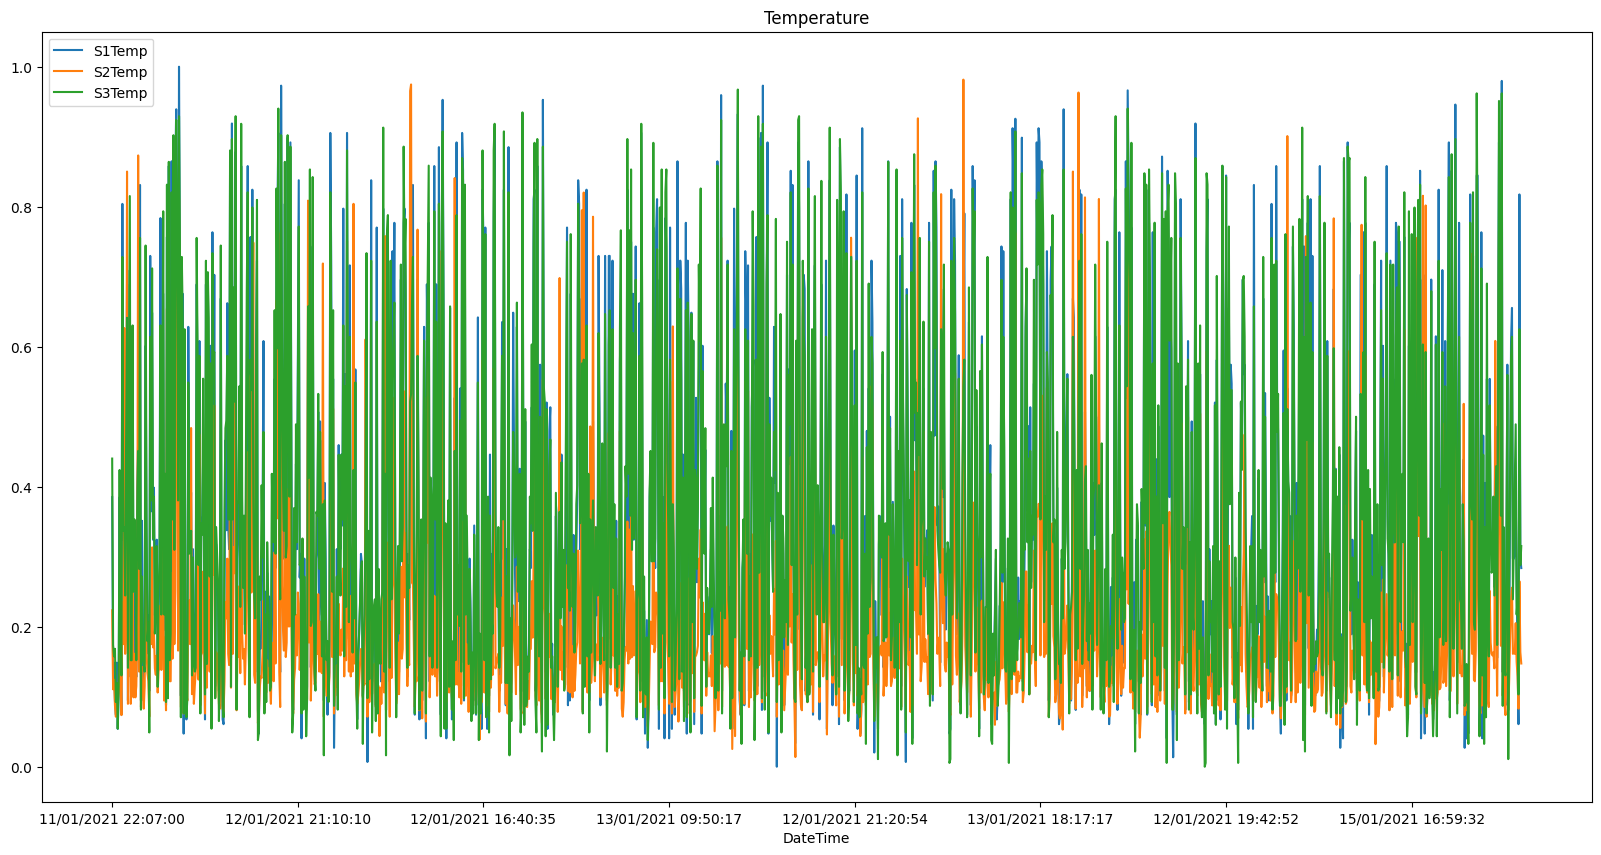

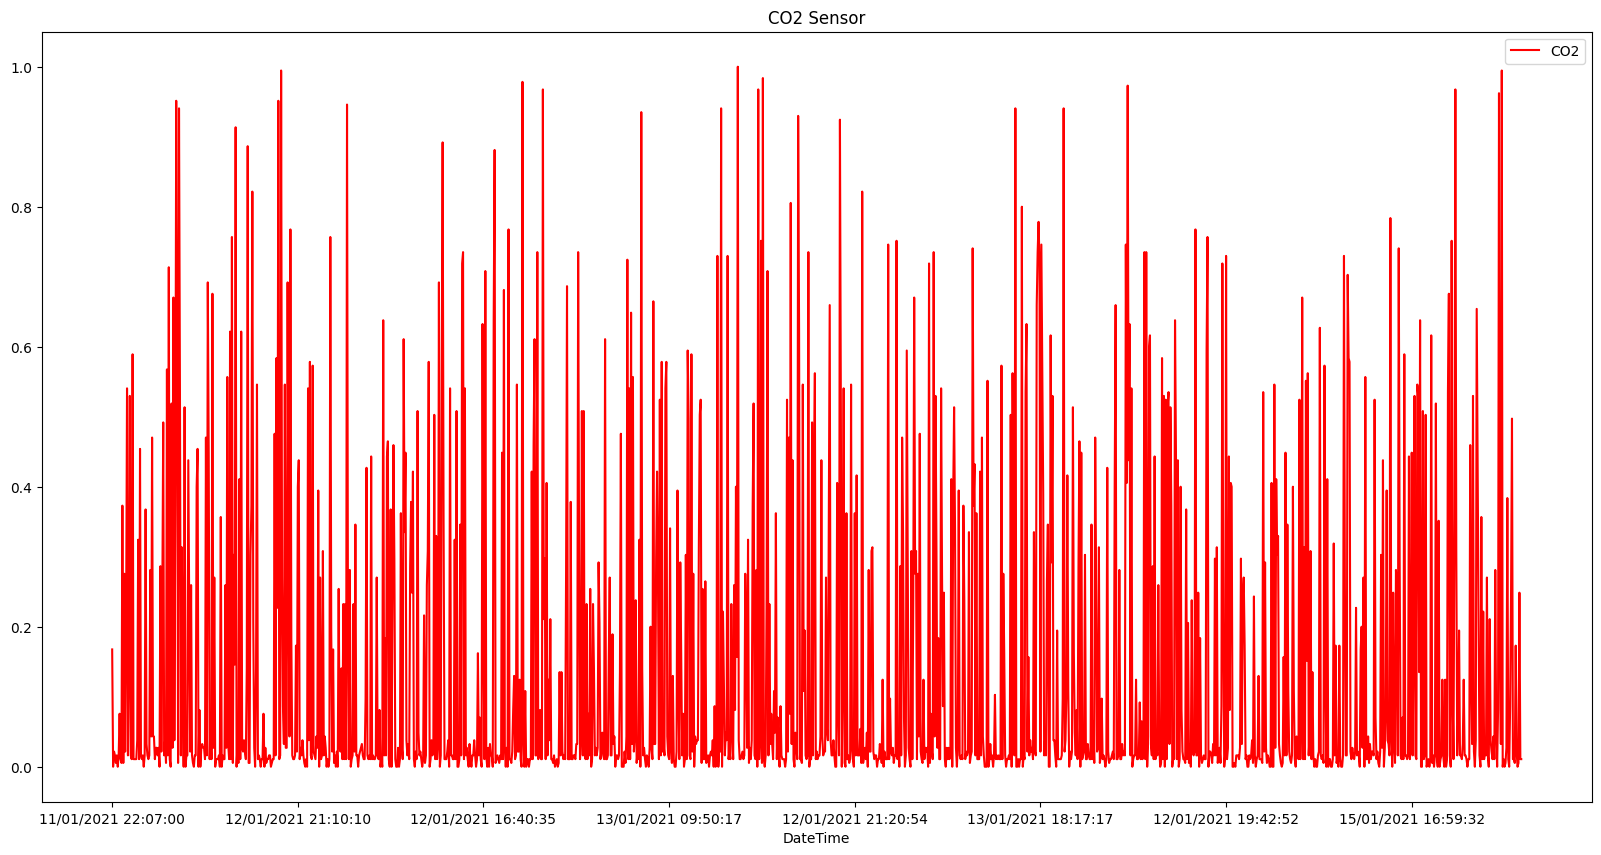

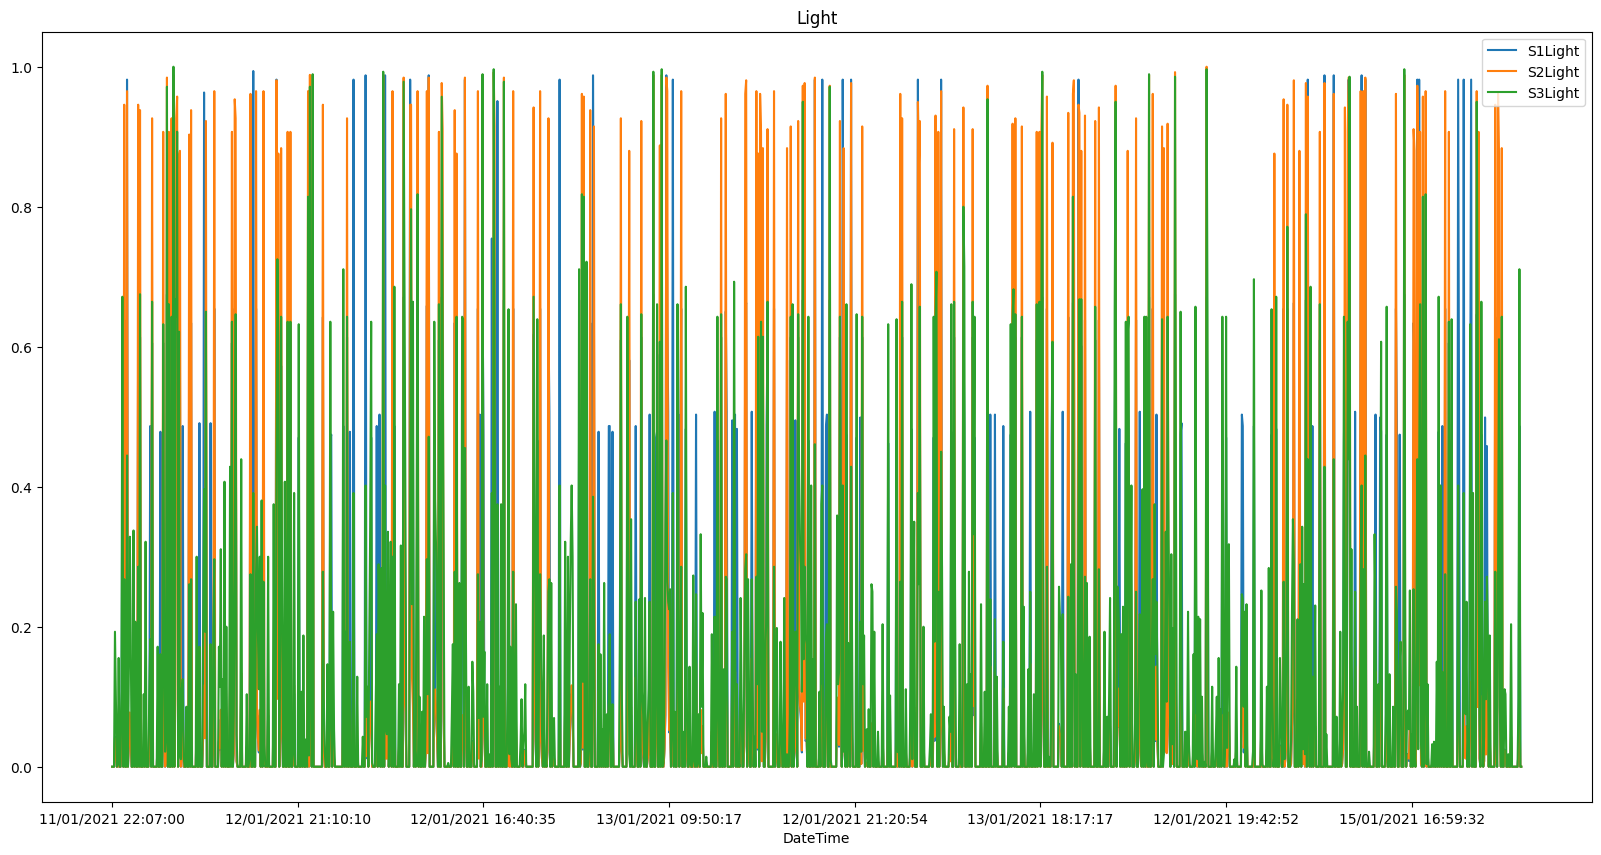

In [6]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# split into train and test sets
train, test = train_test_split(data_df, test_size=0.3, shuffle=True, random_state=1)
test, val = train_test_split(test, test_size=0.5, shuffle=True, random_state=3)
# split into input and ou
y_train_df = train['Persons']
x_train_df = train.drop(['Persons'], axis=1)
y_test_df = test['Persons']
x_test_df = test.drop(['Persons'], axis=1)      
y_val_df = val['Persons']
x_val_df = val.drop(['Persons'], axis=1)


# Normalize data with Min Max 
x_train_df, x_train_df_min, x_train_df_max = normalize_train_set(x_train_df)
x_test_df = normalize_test_set(x_test_df, x_train_df_min, x_train_df_max)
x_val_df = normalize_test_set(x_val_df, x_train_df_min, x_train_df_max)
plot_data(x_test_df, temperature=True, CO2=True, light=True)


x_train_df = x_train_df.drop(['DateTime'], axis=1)
x_val_df = x_val_df.drop(['DateTime'], axis=1)
x_test_df = x_test_df.drop(['DateTime'], axis=1)


# Train the NN (K-Fold method)

In [7]:
# Train scikit NN
from unittest import result
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score



#Implementing cross validation
k = 5
kf = KFold(n_splits=k, random_state=None)
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=([7,5]), random_state=21, learning_rate_init=0.04)


acc_score = []
press_score = []
rec_score = []

x = x_train_df
y = y_train_df 

x_test = x_test_df
y_test = y_test_df

for train_index , test_index in kf.split(x):
    x_train_1, x_val_1 = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train_1 , y_val_1 = y.iloc[train_index] , y.iloc[test_index]
     
    model.fit(x_train_1,y_train_1)
    pred_values = model.predict(x_val_1)
     
    acc = accuracy_score(pred_values , y_val_1)
    press = precision_score(pred_values,  y_val_1, average='macro')
    recall = recall_score(pred_values,  y_val_1, average='macro')
    
    acc_score.append(acc)
    press_score.append(press)
    rec_score.append(recall)
     
avg_acc_score = sum(acc_score)/k
avg_press_score = sum(press_score)/k
avg_recall_score = sum(rec_score)/k

 
print('accuracy of each fold - {}'.format(acc_score))
print('precision of each fold - {}'.format(press_score))
print('recall of each fold - {}'.format(rec_score))


print('Avg accuracy : {}'.format(avg_acc_score))
print('Avg precision : {}'.format(avg_press_score))
print('Avg recall : {}'.format(avg_recall_score))

y_pred_1 = model.predict(x_test)

print("\n")
print("Accuracy:",accuracy_score(y_test_df, y_pred_1))
print("Precision:",precision_score(y_test_df, y_pred_1, average='macro'))
print("Recall:",recall_score(y_test_df, y_pred_1, average='macro'))
print("Confusion:\n",confusion_matrix(y_test_df, y_pred_1))    
print("\n")


accuracy of each fold - [0.9922425952045134, 0.9851904090267983, 0.9929428369795342, 0.9830628087508821, 0.9865913902611151]
precision of each fold - [0.9784492883157706, 0.9490874363327674, 0.9759823623131549, 0.9571879808261332, 0.9537538021307417]
recall of each fold - [0.9723669899392731, 0.9561312752758087, 0.9863047148841584, 0.9448788623295393, 0.9663676144383948]
Avg accuracy : 0.9880060080445686
Avg precision : 0.9628921739837135
Avg recall : 0.9652098913734349


Accuracy: 0.9855167873601053
Precision: 0.9688516652672823
Recall: 0.9569444444444445
Confusion:
 [[1185    0    0    0]
 [   0   59    1    0]
 [   0    0  136    8]
 [   6    0    7  117]]




In [8]:
print(y_test_df)

1235    0
9280    0
1853    0
5301    0
7973    0
       ..
9196    0
7976    0
3399    2
7163    0
7098    0
Name: Persons, Length: 1519, dtype: int64


In [9]:
# Train scikit NN
from unittest import result
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# define model
#Config: {'activation': 'relu', 'hidden_layer_sizes': (30, 70), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 30, 'solver': 'sgd'}
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=([7,5]), random_state=21, learning_rate_init=0.04)
#it uses default the relu to activation

    
#7,5 (bons resultados)


# fit model ignoring DateTime column
#drop DateTime column

model.fit(x_train_df, y_train_df)



# make a prediction
y_val_pred = model.predict(x_val_df)

print(len(y_val_pred))


y_pred = model.predict(x_test_df)
print(len(y_pred))

print("Validate")
print("Accuracy:",accuracy_score(y_val_df, y_val_pred))
print("Precision:",precision_score(y_val_df, y_val_pred, average='macro'))
print("Recall:",recall_score(y_val_df, y_val_pred, average='macro'))
print("Confusion:\n",confusion_matrix(y_val_df, y_val_pred))   
print("\n\n")
print("Test")
print("Accuracy:",accuracy_score(y_test_df, y_pred))
print("Precision:",precision_score(y_test_df, y_pred, average='macro'))
print("Recall:",recall_score(y_test_df, y_pred, average='macro'))
print("Confusion:\n",confusion_matrix(y_test_df, y_pred))    
print("\n")

1519
1519
Validate
Accuracy: 0.9881500987491771
Precision: 0.9648080542950181
Recall: 0.9673324619520353
Confusion:
 [[1188    2    0    1]
 [   1   76    0    0]
 [   0    0  129    3]
 [   0    0   11  108]]



Test
Accuracy: 0.9842001316655694
Precision: 0.9607748789339445
Recall: 0.9525373931623932
Confusion:
 [[1185    0    0    0]
 [   0   59    1    0]
 [   0    1  139    4]
 [   3    0   15  112]]




In [10]:


def TestMe(file):
    prof_test = pd.read_csv(file, sep=",", decimal=".")
    prof_test=parse_date_time(prof_test)
    
    prof_test = drop_outliners(prof_test, threshold=6,
                         collumn_to_remove_outliers=
                         ["S1Temp", "S2Temp","S3Temp",
                          "CO2","PIR1", "PIR2","S1Light",
                           "S2Light","S3Light"])

    
    prof_test = prof_test.interpolate(method='linear', limit_direction='forward', axis=0)
    
    y_prof = prof_test['Persons']
    x_prof = prof_test.drop(['Persons'], axis=1)
    x_prof = x_prof.drop(['DateTime'], axis=1)
    
    x_prof = normalize_test_set(x_prof, x_train_df_min, x_train_df_max)
    
    y_pred_prof = model.predict(x_prof)
    
    c_matrix = confusion_matrix(y_prof, y_pred_prof)
    
    print("\n")
    print("Here's the confunsion matrix obtained")
    print(c_matrix)
    print("\n")
    print("Macro-Precision:  ",precision_score(y_prof, y_pred_prof, average='macro')*100, "%")
    print("Macro-Recall:     ",recall_score(y_prof, y_pred_prof, average='macro')*100, "%")
    print("Macro-F1:         ", f1_score(y_prof, y_pred_prof, average='macro')*100, "%")
    print("\n")
    
    for i in range(4):
        print("Precision (",i,"persons):  ", c_matrix[i][i] / np.sum(c_matrix[i]) * 100,"%")
    
    print("\n")
    
    for i in range(4):
        aux = 0
        for j in range(4):
            aux += c_matrix[j][i]
            
        print("Recall (",i,"persons):  ", c_matrix[i][i] / aux *100,"%")
        aux = 0
    

#this function takes an input the name of a file and remove outliers, interpolates the missing, 
#normalizes and predicts outputs 



In [11]:
TestMe("proffunc.csv")

Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


Here's the confunsion matrix obtained
[[7983    9    0    2]
 [   8  454    5    0]
 [   0    2  850   31]
 [   9    0   69  703]]


Macro-Precision:   96.23238873532965 %
Macro-Recall:      95.8385539104242 %
Macro-F1:          96.00283429268218 %


Precision ( 0 persons):   99.8623967975982 %
Precision ( 1 persons):   97.21627408993577 %
Precision ( 2 persons):   96.26274065685165 %
Precision ( 3 persons):   90.01280409731113 %


Recall ( 0 persons):   99.7875 %
Recall ( 1 persons):   97.63440860215053 %
Recall ( 2 persons):   91.991341991342 %
Recall ( 3 persons):   95.5163043478261 %
